## Discrete supply decisions - example battery in continuous intraday markets

We often face discrete execution decisions in energy. Those may be shippings (e.g. LNG) or order books in futures markets. Another example are continuous intraday power or gas markets.  Let us focus on the latter in this example of optimizing a battery directly against an intraday power order book.

Our example: The main market targeted by battery storage (besides reserve markets) is the power intraday market. When power prices are low, the battery is charged, to be discharded at higher power prices. When optimizing a battery against the intraday market, a typical simplification is to assume there is a price for each time interval (such as 15min in central Europe). Following this optimization, we pass the position to our autotrader, that targets to close the position at the assumed price curve (or better, naturally). 

This simplification is often good, but does not account for significant features if the market: 
* Orders may have to be executed all or nothing. If orders are large as compared to the battery, this cannot be neglected
* Bid ask spread. There may be a significant price gap between buying and selling
* Limited liquidity. We may not be able to trade the full dispatch potential of the battery. Particularly for shallow markets and large assets this may have a significant effect

Note how we consistently solve for an exact match between battery dispatch and order execution. If a direct link to an autotrader is established, this enables us to do a direct execution. Naturally there are many aspects to be accounted for in real life from this static demo to a live solution with a changing order and position tracker.

### Some prerequisites

Import relevant packages and set links. Note that we set a random seed for the generation of our randomized order book.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
# in case eao is not installed
import  os
import sys
# in case eao is not installed, set path
myDir = os.path.join(os.getcwd(), '../..')
sys.path.append(myDir)
addDir = os.path.join(os.getcwd(), '../../../..')
sys.path.append(addDir)

import eaopack as eao

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(6924)

### Setup (1) Basics 

Defining start, end and time grid. Here we optimize over a full day in an hourly granularity. That's an artificial choice for sake of visual clarity, of course.

In [2]:
node = eao.assets.Node('power')
S = dt.date(2021,1,1)
E = dt.date(2021,1,2)
timegrid = eao.assets.Timegrid(S, E, freq = 'h') # using hours for better visualization

### (2) Order book

As the first ingredient we generate a randomized order book with orders of various prices, capacities and duration

In [3]:
# create larger number of orders
## some time steps, buy & sell
ob = pd.DataFrame(columns = ['start', 'end', 'capa', 'price']) # alternative to dict is DataFrame ... converted in asset
r = dict() # row
### orders
# orders with bid/ask spread on base signal
# base signal
bs = (30*np.sin(timegrid.I/24*2*np.pi*2)+40).round(0) + 0*np.random.randn(timegrid.T).cumsum()
prices = {'av': bs}
for ii in timegrid.I:
    tp = timegrid.timepoints[ii]
    # sell (they sell)
    for i in range(0,5):
        r['start']   = tp
        r['end']     = tp + pd.Timedelta(np.random.randint(1, 4), 'h')
        r['capa']    = np.random.randint(1, 4)
        r['price']   = bs[ii] + np.random.randint(10, 50)
        ob.loc[len(ob)] = r
    # buy (they buy)
    for i in range(0,5):
        r['start']   = tp
        r['end']     = tp + pd.Timedelta(np.random.randint(1, 4), 'h')
        r['capa']    = -np.random.randint(1, 4)
        r['price']   = bs[ii] + np.random.randint(-10, 10)
        ob.loc[len(ob)] = r            


The artificial order book shown with their price against time of delivery. The thickness of the orders indicates their sice

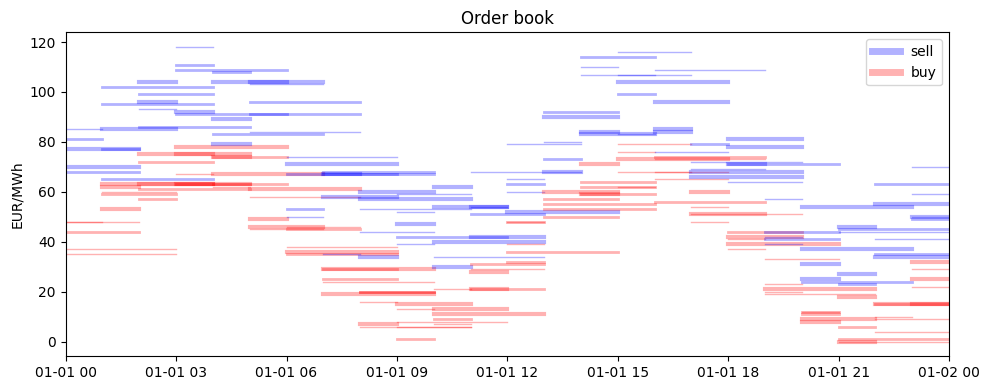

In [4]:
plt.rcdefaults()
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout = True)
#out['dispatch'].loc[:,'battery'].plot(ax = ax)
for i,r in ob.iterrows():
    if r['capa']>0  :  ax.plot([r['start'], r['end']], [r['price'],r['price']],'b-',linewidth = abs(r['capa']), alpha = 0.3)
    elif r['capa']<0:  ax.plot([r['start'], r['end']], [r['price'],r['price']],'r-',linewidth = abs(r['capa']), alpha = 0.3)
ax.set_title('Order book')
ax.set_ylabel('EUR/MWh')
# for legend only
ax.plot([S, S], [0,0],'b-',linewidth = 5, alpha = 0.3, label = 'sell')
ax.plot([S, S], [0,0],'r-',linewidth = 5, alpha = 0.3, label = 'buy')
ax.legend(loc = 'upper right')
ax.set_xlim(S, E)
plt.show()

### (3) Assets

Order book: We utilize a specific asset in EAO to implement the behaviour of the order book. Note that the asset has a parameter "full_exec". Setting it to False, the optimizer is allowed to execute parts of an order -- and the optimization problem is continuous and thus very fast (on my laptop 1.4s). In reality most of the orders will still be executed fully due to the nature of the problem setup. If required, the parameter may be set to True, resulting in a more complex MIP as orders must be executed fully (6.6s).

Battery: Our main asset is a battery storage. We choose artificial parameters such as 95% efficiency and a size of 40 MWh as compared to a capacity of 10 MW (a 4h battery). Note that we need to specifc a start and a target fill level.

Target fill level flex: The target fill level requires some additional thoughts. Left unpenalized, an optimizer will completely drain a battery at the end of the day (in case power prices are positive). In order to avoid this we need to define the value battery power has for us towards the end of the day. We do this by forcing the battery to be left at 50% fill level and adding an "extra source" for power with a market price above the order book. Power drawn from this "extra source" represents battery usage from this 50% target fill level.



In [5]:
# order book asset
order_book = eao.assets.OrderBook('orders', node, 
                                    orders    = ob, 
                                    full_exec = True)  # switch to enforce (or not) full order execution

# battery
efficiency = 0.95
battery = eao.assets.Storage('battery', node, cap_in      = 10, 
                                        cap_out     = 10,
                                        start_level = 20,
                                        end_level   = 20,
                                        eff_in      = efficiency,
                                        size        = 40,
                                        no_simult_in_out = True) # at negative prices, we want to ensure the battery does not charge & discharge at the same time to "burn" power
# last resort - battery end level. May allow battery not to be completely full, "borrowing" in last hours
extra_power = eao.assets.SimpleContract('fill_level_adjust', node,
                                max_cap   = 10,
                                min_cap   = 0,
                                start     = timegrid.timepoints[-2],
                                end       = E,
                                price     = 'av',
                                extra_costs = 20
                                )

### (4) Setting up the portfolio

In EAO we can easily link all assets in a portfolio. By refering to the same node we ensure their dispatch sums to zero.

In [6]:
portf = eao.portfolio.Portfolio([battery, order_book, extra_power])

## Perform the optimization

Once the portfolio is set up, optimization can be called and the output extracted.

In [7]:
op = portf.setup_optim_problem(prices=prices, timegrid=timegrid)
res = op.optimize(solver = 'SCIP')
out = eao.io.extract_output(portf= portf, op=op, res=res)

## Create charts and interpret the results

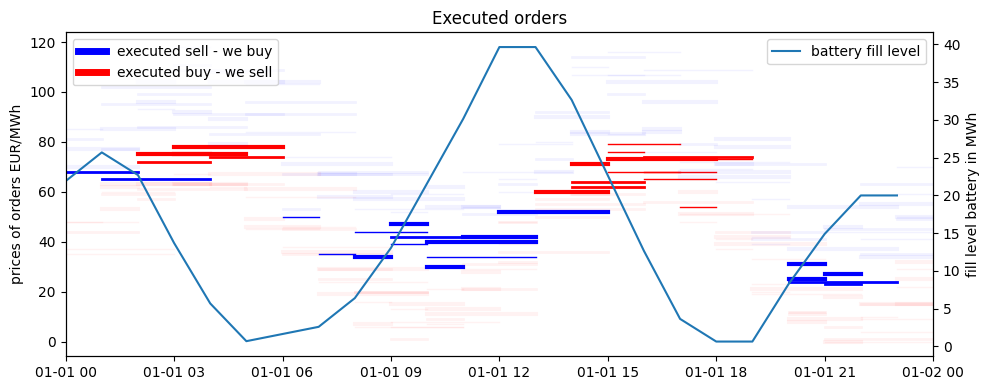

In [8]:
plt.rcdefaults()
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout = True)
for i,r in ob.iterrows():
    if out['special'].loc[i,'value'] > 0.95: myal = 1
    else: myal = 0.05 # executed
    if   r['capa']>0: ax.plot([r['start'], r['end']], [r['price'],r['price']],'b-',linewidth = abs(r['capa']), alpha = myal)
    elif r['capa']<0: ax.plot([r['start'], r['end']], [r['price'],r['price']],'r-',linewidth = abs(r['capa']), alpha = myal)
ax.set_title('Executed orders')
ax.set_ylabel('prices of orders EUR/MWh')
ax.plot([S, S], [0,0],'b-',linewidth = 5, alpha = 1, label = 'executed sell - we buy')
ax.plot([S, S], [0,0],'r-',linewidth = 5, alpha = 1, label = 'executed buy - we sell')
ax.set_xlim(S, E)
ax2 = ax.twinx() 
### show how to manually calculate fill level from dispatch
# fill_level = -out['dispatch'].loc[:,'battery']
# fill_level[fill_level>0] *= efficiency
# fill_level = fill_level.cumsum()+20 
### this is the automatic output
fill_level = out['internal_variables']['battery_fill_level']
ax2.plot(fill_level, label = 'battery fill level')
ax2.set_ylabel('fill level battery in MWh')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

In bold color we can observe orders that have been executed. We have successfully combined a battery with a discrete order book consisting of orders that are partly overlapping and come with various prices and sizes.